### Notebook for fuel moisture / Samuli 24.8.2022

In [26]:
from canopywind import wind_profile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
from utils import read_forcing
ffile = r'Data/Hyytiala/FIHy_forcing_1997_2019.dat'

forc = read_forcing(ffile, '2006-05-01', '2006-10-31')

dforc = forc.resample('1D').mean()

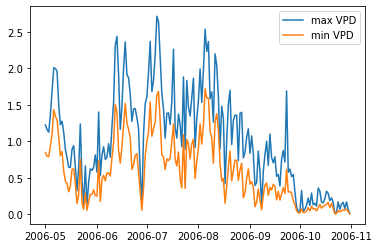

In [27]:
# daily forcing
dforc = forc.resample('1D').mean()
dforc['Prec'] = forc['Prec'].resample('1D').sum()*1800 # mm/d
dforc['Tmax'] = forc['Tair'].resample('1D').max()
dforc['VPDmax'] = forc['VPD'].resample('1D').max()

dforc['RHmin'] = forc['RH'].resample('1D').min()

plt.plot(dforc['VPDmax'], label='max VPD')
plt.plot(dforc['VPD'], label= 'min VPD')
plt.legend()

### Test fuel moisture equilibration with ambient conditions using small and large tau

This one is now described in the manuscript dead-fuel section

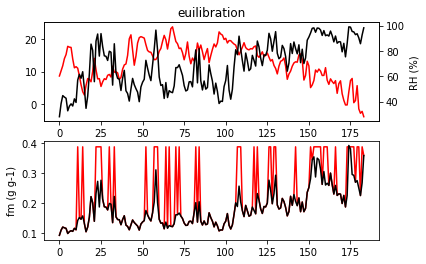

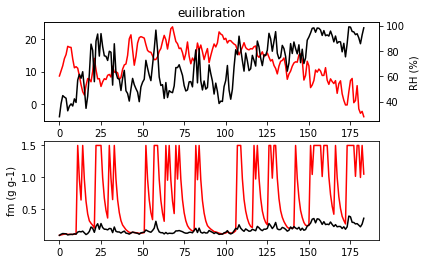

In [29]:
from fuel_models import FM_equilibration
fig.set_size_inches(8,6)
# test with 1/2 forcing
tau = 3.0 # h
dt = 24.0 # h

T = dforc['Tair'].values
RH = dforc['RH'].values
RH = np.maximum(RH, 1.0)
RH = np.minimum(RH, 99.0)
Prec = dforc['Prec'].values
#fm_c, EMC = FM_catchpole(T, RH, dt, tau)
fm_f, EMCf = FM_equilibration(T, RH, Prec, dt, tau=3.0, fm_max=None, Prec_lim=1.0)
fmc_l, EMCl = FM_equilibration(T, RH, Prec, dt, tau=48.0, fm_max=1.5, Prec_lim=1.0)

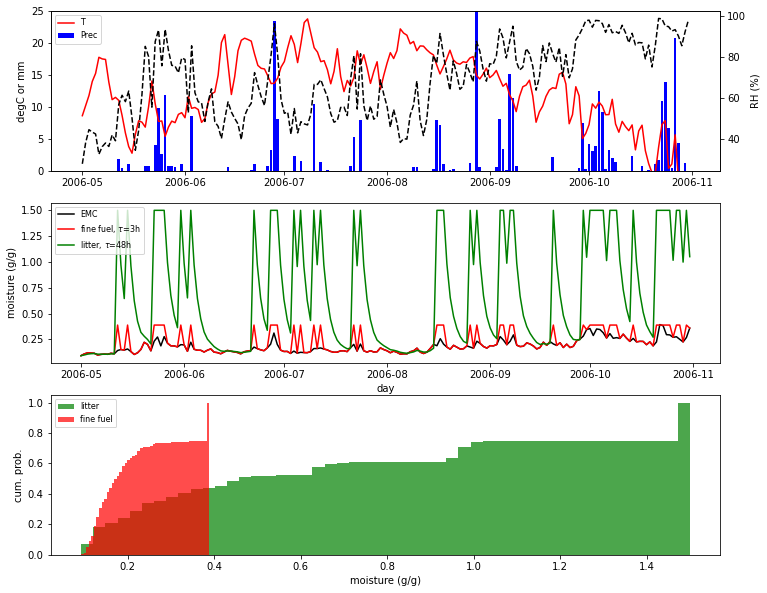

In [31]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(12,10)
t = dforc.index
ax[0].bar(t, Prec, color='b', label='Prec')
ax[0].plot(t, T, 'r-', label='T')
ax[0].set_ylabel('degC or mm')
ax[0].set_ylim([0, 25])
axb = ax[0].twinx()

axb.plot(t, RH, 'k--', label='RH')
axb.set_ylabel('RH (%)')
ax[0].legend(fontsize=8)

ax[1].plot(t, EMCf, 'k-', label='EMC')
ax[1].plot(t, fm_f, 'r-', label='fine fuel, $\\tau$=3h')
ax[1].plot(t, fmc_l, 'g-', label='litter, $\\tau$=48h')
ax[1].legend(fontsize=8)
ax[1].set_ylabel('moisture (g/g)')
ax[1].set_xlabel('day')

ax[2].hist(fmc_l, 50, density=True, cumulative=True, alpha=0.7, color='g', label='litter')
ax[2].hist(fm_f, 50, density=True, cumulative=True, alpha=0.7, color='r', label='fine fuel')
ax[2].set_ylabel('cum. prob.')
ax[2].set_xlabel('moisture (g/g)')
ax[2].legend(fontsize=8)

fig.savefig(r'Results\litter_moisture_hyde_2006.png', dpi=300)

### Nelson 1984 equilibrium moisture - convert parameters to meet q = a + b ln(-RT/M ln h); direct conversion was a not clear (units?)

In [32]:
# nelson Table 1
A = np.array([4.745, 5.176, 4.644, 4.898, 4.585, 4.673, 5.481, 5.5357, 5.13, 5.252])
B = np.array([-15.495, -14.379, -13.730, -11.652, -16.69, -13.893, -21.412, -16.630, -20.697, -18.353])

def EMC_nelson(h, a, b):
    T = 25.0
    R = 1.987 # cal mol-1
    Mw = 18.015 # g mol-1
    q = 1/b * np.log(-R*(T+273.15) / (Mw * np.exp(a)) * np.log(h))
    return q

def EMC(h, a, b):
    # equilibrium moisture content
    T = 25.0
    R = 1.987 # cal mol-1
    Mw = 18.015 # g mol-1
    q = a + b* np.log(-R*(T+273.15) / Mw  * np.log(h))
    return q

def EMC_si(h, a, b):
    T = 25.0
    R = 8.314 # J kg mol-1
    Mw = 18.015e-3 # kg mol-1
    q = a + b* np.log(-R*(T+273.15) / Mw  * np.log(h))
    return q    


In [33]:
# fit curve
from scipy.optimize import curve_fit
plt.figure()
T = 25.0
h = np.linspace(0.01, 0.99, 50)
para = []
for k in range(len(A)):
    q = EMC_nelson(h, A[k], B[k])
    p, pcov = curve_fit(EMC, h, q)
    m = EMC(h, p[0], p[1])
    #plt.figure(k)
    #plt.plot(h, q, '-'); plt.plot(h, m, '--')
    print(p)
    para.append(p)

[ 0.30622782 -0.06453695]
[ 0.3599694  -0.06954587]
[ 0.33823744 -0.07283321]
[ 0.42035702 -0.08582218]
[ 0.2747154  -0.05991612]
[ 0.33635644 -0.07197869]
[ 0.25597796 -0.04670278]
[ 0.33287432 -0.06013229]
[ 0.24786201 -0.04831618]
[ 0.28616575 -0.054487  ]


<Figure size 432x288 with 0 Axes>

### Draw EMC -curves from literature and seek for generic parameters for EMC-curve (result embedded in FM_equilibration)

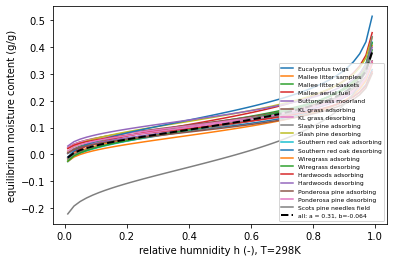

In [34]:
p = pd.read_csv(r'Literature\Equilibrium_isotherm_parameters.txt', sep=';', header='infer')
#p = p.astype({'fuel':'str','a':'float', 'b':'float', 'tau': 'float'})


plt.figure()

n = len(p)
h = np.linspace(0.01, 0.99, 50)
xdata = []
ydata = []
for k in range(n):
    q = EMC(h, p['a'][k], p['b'][k])
    plt.plot(h, q, '-', label=p['fuel'][k])
    xdata.extend(h)
    ydata.extend(q)
    
#plt.legend(fontsize=6)

# fit generic equation to all data
para, pcov = curve_fit(EMC, xdata, ydata)
Q = EMC(h, para[0], para[1])
plt.plot(h, Q, 'k--', linewidth=2, label = 'all: a = %.2f, b=%.3f' %(para[0], para[1]))
plt.legend(fontsize=6)
plt.ylabel('equilibrium moisture content (g/g)')
plt.xlabel('relative humnidity h (-), T=298K')
plt.savefig(r'Results/EMC_finefuels.png', dpi=300)

### Estimate characteristic tau for litter layer; use Matthews et al. (2007) data

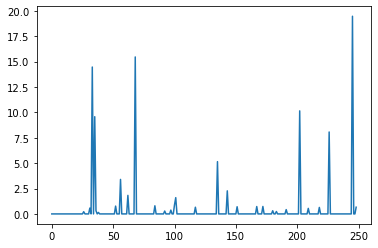

In [35]:
from scipy import interpolate

pmc = pd.read_csv(r'Literature\Matthews_Fig3_karriPMC.txt',sep=';', header='infer', comment='%')
smc = pd.read_csv(r'Literature\Matthews_Fig3_karriSMC.txt',sep=';', header='infer', comment='%')

Td = pd.read_csv(r'Literature\Matthews_Fig3_temp.txt',sep=';', header='infer', comment='%')
Tmax = pd.read_csv(r'Literature\Matthews_Fig3_tmax.txt',sep=';', header='infer', comment='%')
P = pd.read_csv(r'Literature\Matthews_Fig3_prec.txt',sep=';', header='infer', comment='%')

# interpolate to same grid
t = pmc['day'].values

data = np.zeros((len(t), 6))
# day, pmc, smc, T, RH, Prec
data[:,0] = t
f = interpolate.interp1d(pmc['day'].values, pmc['fm'],fill_value="extrapolate")
data[:,1] = f(t)
f = interpolate.interp1d(smc['day'].values, smc['fm'], fill_value="extrapolate")
data[:,2] = f(t)

f = interpolate.interp1d(Tmax['day'].values, Tmax['var'], fill_value="extrapolate")
Tmax = f(t)
# td and Tmin approx same
f = interpolate.interp1d(Td['day'].values, Td['var']-2, fill_value="extrapolate")
Td = f(t)

T = (Tmax + Td ) / 2
RH = RH = np.exp(17.625 * Td/(243.04 + Td)) / np.exp(17.625 * T/(243.04 + T))
data[:,3] = T
data[:,4] = RH

# precipitation

pp = np.zeros(len(t))
tt = P['day'].values
P0 = P['var'].values
for k in range(len(tt)):
    dt = np.abs((t - tt[k]))
    ix = np.where(dt == np.min(dt))[0]
    #print(k, ix)
    if len(ix)>0:
        pp[ix] = np.mean(P0[k])

        
data[:,5] = pp

plt.figure()
plt.plot(data[:,5])


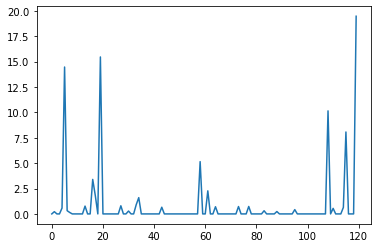

In [36]:
tt = np.arange(0, 120)
dat = np.zeros((len(tt), 6))
dat[:,0] = tt
for k in range(1,5):
    f = interpolate.interp1d(data[:,0], data[:,k], kind='nearest')
    dat[:,k] = f(tt)

# precipitation
pp = np.zeros(len(tt))
t0 = P['day'].values
P0 = P['var'].values
for k in range(len(t0)):
    dt = np.abs((tt - t0[k]))
    ix = np.where(dt == np.min(dt))[0]
    #print(k, ix)
    if len(ix)>0:
        pp[ix] = np.mean(P0[k])

dat[:,5] = pp
dat[:,1]
T = dat[:,3]
RH = 100 * dat[:,4]

P = dat[:,5]

plt.figure()
plt.plot(P)

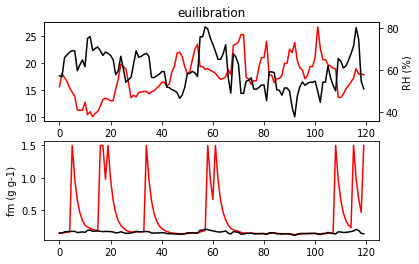

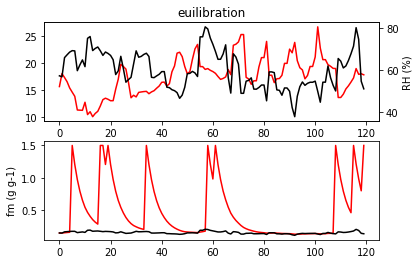

In [37]:
from fuel_models import FM_equilibration
dt = 24.0
tau = 200.0
Prec_lim = 1.0
fm_max = 2.0

fm, em = FM_equilibration(T, RH, P, dt, tau=48, fm_max=1.5, Prec_lim=1.0)
fm2, em2 = FM_equilibration(T, RH, P, dt, tau=96, fm_max=1.5, Prec_lim=1.0)



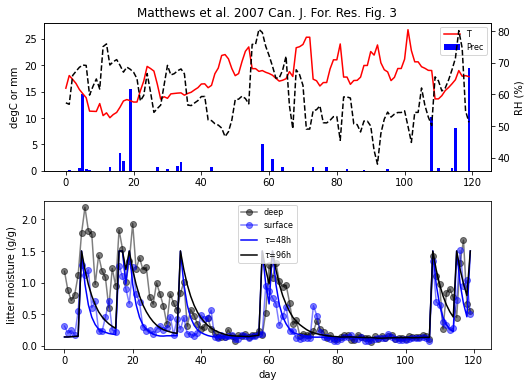

In [40]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(8,6)
ax[0].bar(dat[:,0], P, color='b', label='Prec')
ax[0].plot(dat[:,0], T, 'r-', label='T')
ax[0].set_ylabel('degC or mm')
axb = ax[0].twinx()

axb.plot(dat[:,0], RH, 'k--', label='RH')
axb.set_ylabel('RH (%)')
ax[0].legend(fontsize=8)

ax[1].plot(dat[:,0], 1e-2 * dat[:,1], 'ko-', markersize=6, alpha=0.5, label='deep') 
ax[1].plot(dat[:,0], 1e-2 * dat[:,2], 'bo-', markersize=6, alpha=0.5, label='surface')
ax[1].plot(dat[:,0], fm, 'b-', label='$\\tau$=48h')
ax[1].plot(dat[:,0], fm2, 'k-', label='$\\tau$=96h')
ax[1].legend(fontsize=8)
ax[1].set_ylabel('litter moisture (g/g)')
ax[1].set_xlabel('day')
ax[0].set_title('Matthews et al. 2007 Can. J. For. Res. Fig. 3')

fig.savefig(r'Results\litter_moisture.png', dpi=300)



Text(0.5, 0, 'U / U$_o$ (-)')

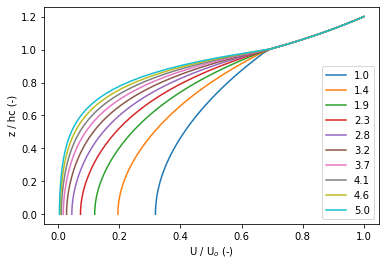

In [41]:
#%% Estimate wind profile for different LAI's

LAI = np.linspace(1.0, 5.0, 10)
Uo = 10.0
hc = 10.0
zm = 2.0
z = np.linspace(0, hc + zm, 50)

res = {'LAI': LAI,
       'U': np.ones((len(LAI), len(z)))*np.NaN,
       'ustar': np.ones(len(LAI))*np.NaN,
       'Uh': np.ones(len(LAI))*np.NaN,
      }

fig, ax = plt.subplots(1,)
for n in range(len(LAI)):
    u, ust, uh = wind_profile(LAI[n], hc, Uo, z)
    res['U'][n,:] = u
    res['ustar'][n] = ust
    res['Uh'][n] = uh
    
    ax.plot(u /Uo, z/hc, '-', label='%.1f' % LAI[n])

ax.legend()
ax.set_ylabel('z / hc (-)')
ax.set_xlabel('U / U$_o$ (-)')


In [13]:
p.columns


Index(['fuel', ' a', ' b', ' tau'], dtype='object')